## Setup

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, leaves_list, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from callbacks import Logger, ReportBestFitness
from checkpoint import CheckPointManager
from custom_types import T_Population
from fn import (fitness_func, fitness_sharing, random_mutation,
                single_point_crossover, tournament_selection)
from ga import GeneticAlgorithm
from population import random_beta_population


In [2]:
def dummy_fitness_func(ga: GeneticAlgorithm, *, ideal_genomes: T_Population) -> np.ndarray:

  # Base fitness calculation (placeholder to be replaced with Dynamo outputs)
  base_fitness = (ga.population @ ideal_genomes.T)
  base_fitness = 1 / (1 + np.exp(-base_fitness))
  base_fitness = np.max(base_fitness, axis=1)

  return base_fitness

def generate_ideal_genomes(n_genomes: int, n_ideal_genes: int, n_genes: int) -> T_Population:

  genomes = np.zeros((n_genomes, n_genes))

  # Randomly select 3 distinct genes for each genome
  selected_genes = np.random.choice(n_genes, (n_genomes, n_ideal_genes), replace=False)

  # Generate random perturbations (-1 or 1) for the selected genes
  perturbations = np.random.choice([-1, 1], (n_genomes, n_ideal_genes))

  # Apply the perturbations
  np.put_along_axis(genomes, selected_genes, perturbations, axis=1)

  return genomes

In [3]:
def population_analysis(population: T_Population, show_dendrogram: bool = True, show_heatmap: bool = True, gene_list=None, ideal_genomes: T_Population = None) -> None:

  # Compute the linkage matrix using Ward's method (minimize the variance of clusters being merged)
  Z = linkage(population, method='ward')
  order = leaves_list(Z)
  clustered_population = population[order]

  if show_dendrogram:

    # Visualize the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(Z)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Individual Index')
    plt.ylabel('Distance')
    plt.show()

  if show_heatmap:

    # Add ideal genomes to heatmap for reference
    # heatmap_pop = np.append(clustered_population, ideal_genomes, axis=0)
    heatmap_pop = clustered_population

    if ideal_genomes is not None:
      heatmap_pop = np.append(heatmap_pop, ideal_genomes, axis=0)

    # Create the heatmap with the clustered population
    plt.figure(figsize=(20, 10))
    sns.heatmap(heatmap_pop, cmap='vlag', center=0,
                linewidths=.5, cbar_kws={"shrink": .5},
                xticklabels=gene_list if gene_list is not None else np.arange(heatmap_pop.shape[1]),
                )

    plt.title('Heatmap of Clustered Genetic Algorithm Population')
    plt.xlabel('Gene Index')
    plt.ylabel('Clustered Individual Index')
    plt.show()

## Instantiate GA and Run

In [4]:
n_genes = 100
n_population = 100
n_generations = 100

n_ideal_genomes = 1
n_ideal_genes = 5
ideal_genomes = generate_ideal_genomes(n_genomes=n_ideal_genomes, n_ideal_genes=n_ideal_genes, n_genes=n_genes)
base_fitness_func = partial(dummy_fitness_func, ideal_genomes=ideal_genomes)

fitness_sharing_func = None
fitness_sharing_func = partial(fitness_sharing,
                               gene_threshold = .25,
                               sharing_radius = 0.25,
                               sharing_level = 2)

ga = GeneticAlgorithm(
  n_generations = n_generations,
  init_population = random_beta_population(shape=(n_population, n_genes)),
  fitness_func = partial(fitness_func, base_fitness_func=base_fitness_func, l1_weight=.2, fitness_sharing=fitness_sharing_func),
  selection_func = partial(tournament_selection, num_parents=2, tournament_size=4),
  keep_parents = False,
  crossover_func = partial(single_point_crossover, crossover_rate=0.5),
  mutation_func = partial(random_mutation, population_generating_func=random_beta_population, mutation_rate=0.01),
)

In [5]:
logger = Logger()

cp = CheckPointManager(ga=ga, logger=logger, save_frequency=0, directory='./checkpoints')

In [7]:
ga.run(callbacks=[ReportBestFitness(), logger, cp])

Generation 000 | Best fitness: 0.781216
Generation 010 | Best fitness: 0.894645
Generation 020 | Best fitness: 0.907979
Generation 030 | Best fitness: 0.917585
Generation 040 | Best fitness: 0.924933
Generation 050 | Best fitness: 0.930210
Generation 060 | Best fitness: 0.932511
Generation 070 | Best fitness: 0.935938
Generation 080 | Best fitness: 0.939302
Generation 090 | Best fitness: 0.942650


## Analysis

<Axes: xlabel='generation'>

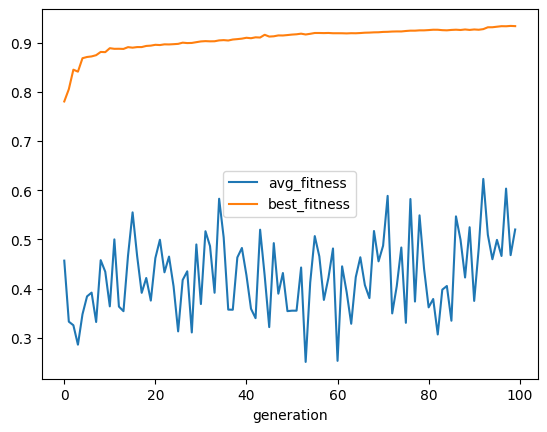

In [ ]:
df = pd.DataFrame(logger.log)

# Plot the average fitness for each generation
df['avg_fitness'] = np.array([np.mean(log_item['fitnesses']) for log_item in logger.log])
df['best_fitness'] = np.array([np.max(log_item['fitnesses']) for log_item in logger.log])
df.plot(x='generation', y=['avg_fitness','best_fitness'])

In [ ]:
# display run time in correct format (e.g. 0.01 second):
print(f"Run time: {logger.get_runtime().total_seconds()} seconds")


Run time: 1.416611 seconds


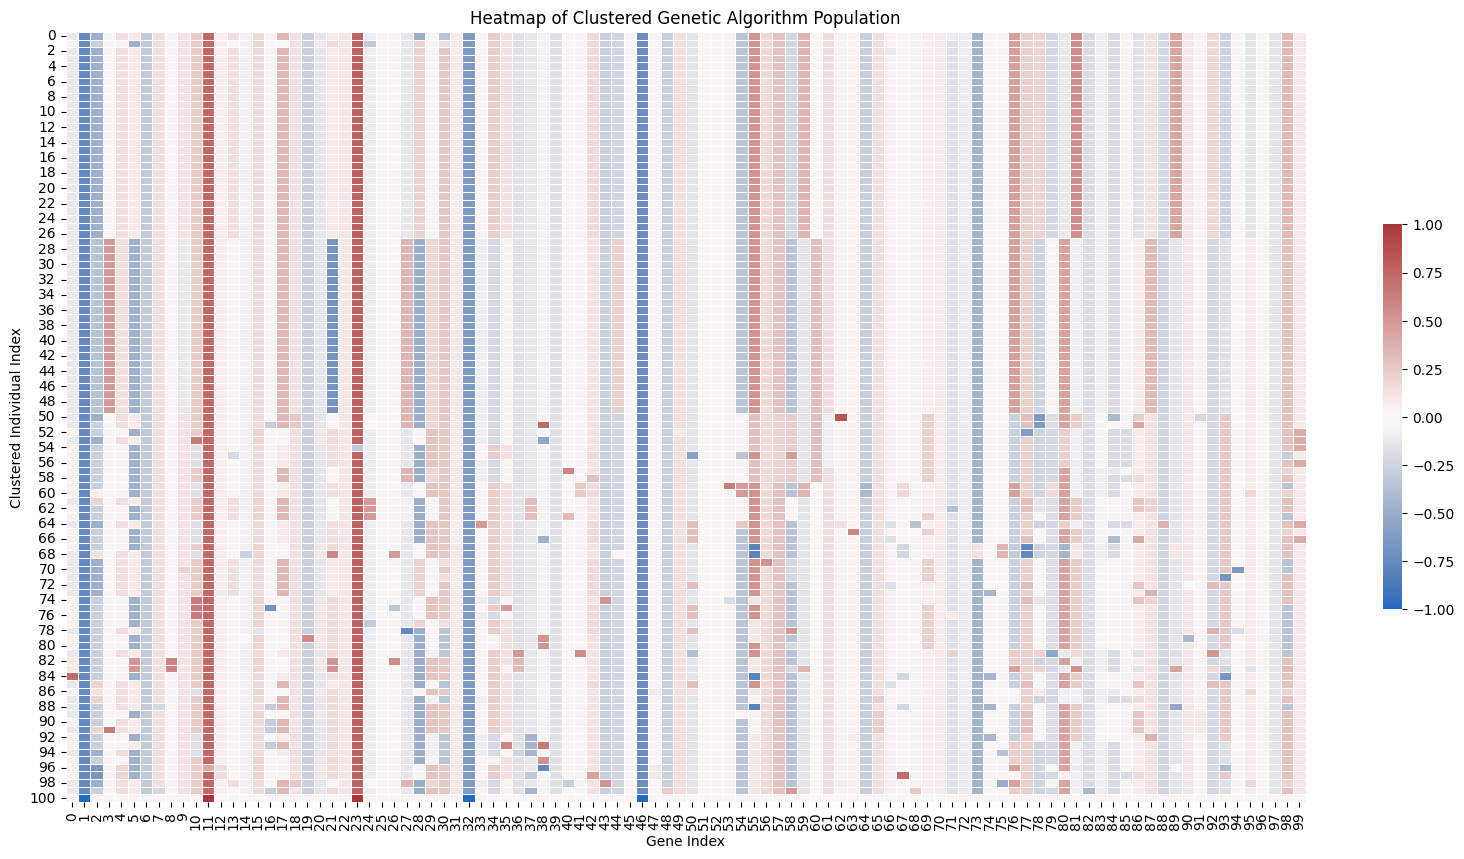

In [ ]:
population_analysis(ga.population, show_dendrogram=False, show_heatmap=True, ideal_genomes=ideal_genomes)

In [8]:
# Inspect contents of the saved checkpoint

import pickle
import pprint  # For pretty printing the contents

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        return data

# Load and print the contents
data = load_pickle('checkpoints/GeneticAlgorithm_2024-04-28_13-53-47_gen_100.pkl')
pprint.pprint(data)

{'checkpoint_name': 'GeneticAlgorithm_2024-04-28_13-53-47',
 'log': [{'fitnesses': array([0.27273169, 0.6259091 , 0.09539205, 0.55761247, 0.21759735,
       0.19245431, 0.4847976 , 0.64879946, 0.71123681, 0.35764103,
       0.24463176, 0.15600431, 0.42885279, 0.37473503, 0.23710872,
       0.19415091, 0.24776617, 0.5006356 , 0.48277928, 0.3767338 ,
       0.35861749, 0.51523666, 0.48637214, 0.57285975, 0.37429014,
       0.55129284, 0.72723685, 0.64633393, 0.41268033, 0.34480921,
       0.48146736, 0.44059116, 0.33855527, 0.69676757, 0.7255856 ,
       0.52498296, 0.34780552, 0.1074909 , 0.69679642, 0.19517399,
       0.47608997, 0.5377412 , 0.1452123 , 0.21724445, 0.65692458,
       0.22971971, 0.77612897, 0.26532978, 0.13547552, 0.63344395,
       0.57125463, 0.43700499, 0.4741412 , 0.23767075, 0.27825217,
       0.61961375, 0.67412424, 0.71366394, 0.38224898, 0.19994735,
       0.45584319, 0.44074387, 0.4394215 , 0.62934739, 0.08570287,
       0.20535913, 0.51839768, 0.34955348, 0.7